In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
%cd '/content/gdrive/MyDrive'

/content/gdrive/MyDrive


In [6]:
%cd 'Introduction to Timeseries/'

/content/gdrive/MyDrive/Introduction to Timeseries


In [7]:
df = pd.read_csv('household_power_consumption.txt', delimiter=';', low_memory=False, header=0, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'], na_values='?')

In [8]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [9]:
df.shape

(2075259, 7)

In [10]:
df.replace("?", np.nan, inplace=True)

In [11]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [12]:
df = df.fillna(df.mean())
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [13]:
df_daily = df.resample('D').sum()
df_daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


Text(0.5, 0, 'dt')

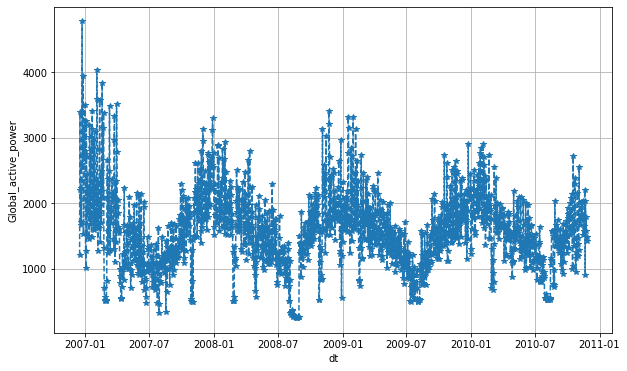

In [14]:
plt.figure(figsize = (10, 6))
plt.plot(df_daily.index, df_daily.Global_active_power, '--', marker = '*', )
plt.grid()
plt.ylabel('Global_active_power')
plt.xlabel('dt')

In [15]:
df['Global_active_power'].corr(df['Global_reactive_power'])

0.24701705264406407

In [16]:

df['Voltage'].corr(df['Global_active_power'])

-0.39976160962896207

In [17]:

df_daily['Voltage'].corr(df_daily['Global_active_power'])

0.062471828475975634

In [18]:

df_daily['Global_active_power'].corr(df_daily['Global_reactive_power'])

0.041097837359968616

In [19]:
df_daily.shape

(1442, 7)

In [20]:
df_daily2= df_daily.reset_index()
df_daily2.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [21]:

df_daily2 = df_daily2[['datetime','Global_active_power']]
new_daily_df= df_daily2.rename(columns={"datetime":"ds","Global_active_power":"y"})

In [22]:
# create test dataset, remove last 12 months
train_df = df_daily2.drop(df_daily2.index[-365:])
print(train_df.tail())

       datetime  Global_active_power
1072 2009-11-22             2450.976
1073 2009-11-23             1471.122
1074 2009-11-24             2128.856
1075 2009-11-25             1980.130
1076 2009-11-26             1599.626


In [23]:
new_train_df= train_df.rename(columns={"datetime":"ds","Global_active_power":"y"})

In [26]:
from prophet import Prophet
model = Prophet()
model.fit(new_train_df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [27]:

future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1437,2010-11-22,2038.931308,1496.386716,2580.722648
1438,2010-11-23,2181.103668,1669.207679,2714.876887
1439,2010-11-24,2192.185077,1667.253342,2772.422856
1440,2010-11-25,2024.913261,1441.061011,2575.835506
1441,2010-11-26,2155.222509,1582.384354,2735.769319


In [28]:
# calculate MAE between expected and predicted values for december
y_true = df_daily2['Global_active_power'][-365:].values
y_pred = forecast['yhat'][-365:].values

In [29]:
MAE = np.mean(np.abs((y_true - y_pred)/y_true))
MAE

0.20884985090046293

In [30]:
y_true.shape

(365,)

In [31]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
round(rmse, 3)

374.953

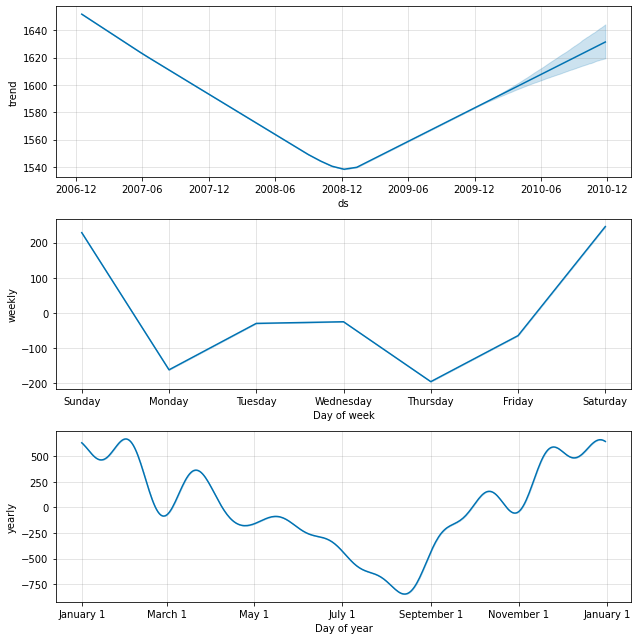

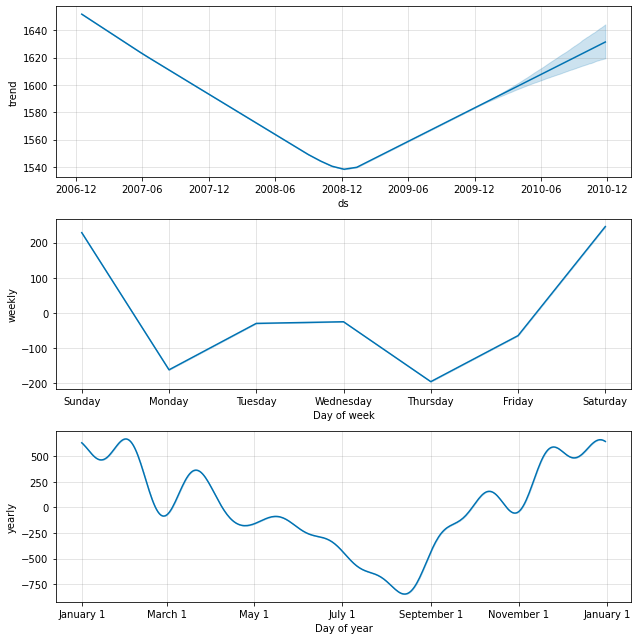

In [32]:
model.plot_components(forecast)

In [33]:
df_daily.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [34]:
new_df= df_daily.reset_index()
new_df.head()

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [35]:
df_index = new_df.rename(columns= {'dt': 'ds', 'Global_active_power':'y'})
df_index.head()

,datetime,y,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,1209.176,34.922,93552.53,5180.8,0.0,546.0,4926.0
1,2006-12-17,3390.460,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2,2006-12-18,2203.826,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
3,2006-12-19,1666.194,150.942,348479.01,7094.0,839.0,7602.0,6197.0
4,2006-12-20,2225.748,160.998,348923.61,9313.0,0.0,2648.0,14063.0


In [36]:
train_df2 = df_index.drop(df_index.index[-365:])
train_df2.tail()

,datetime,y,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
1072,2009-11-22,2450.976,222.638,347151.89,10358.2,6774.0,411.0,16097.0
1073,2009-11-23,1471.122,148.338,349549.51,6100.8,0.0,402.0,8230.0
1074,2009-11-24,2128.856,153.820,348446.20,8899.0,2491.0,4579.0,9086.0
1075,2009-11-25,1980.130,175.476,347297.45,8309.2,745.0,5083.0,10596.0
1076,2009-11-26,1599.626,141.542,349406.59,6640.2,2262.0,407.0,10069.0


In [37]:
new_train_df2= train_df2.rename(columns={"datetime":"ds"})

In [38]:
new_train_df2.tail()

,ds,y,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
1072,2009-11-22,2450.976,222.638,347151.89,10358.2,6774.0,411.0,16097.0
1073,2009-11-23,1471.122,148.338,349549.51,6100.8,0.0,402.0,8230.0
1074,2009-11-24,2128.856,153.820,348446.20,8899.0,2491.0,4579.0,9086.0
1075,2009-11-25,1980.130,175.476,347297.45,8309.2,745.0,5083.0,10596.0
1076,2009-11-26,1599.626,141.542,349406.59,6640.2,2262.0,407.0,10069.0


In [39]:
#Adding external regressors
model = Prophet()
model.add_regressor('Global_reactive_power')
model.add_regressor('Voltage')
model.add_regressor('Global_intensity')
model.add_regressor('Sub_metering_1')
model.add_regressor('Sub_metering_2')
model.add_regressor('Sub_metering_3')
model.fit(new_train_df2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [40]:
pred = model.make_future_dataframe(periods=365, freq='D')

In [41]:
pred['Global_reactive_power'] = df_index['Global_reactive_power']
pred['Voltage'] = df_index['Voltage']
pred['Global_intensity'] = df_index['Global_intensity']
pred['Sub_metering_1'] = df_index['Sub_metering_1']
pred['Sub_metering_2'] = df_index['Sub_metering_2']
pred['Sub_metering_3'] = df_index['Sub_metering_3']
pred

,ds,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,34.922,93552.53,5180.8,0.0,546.0,4926.0
1,2006-12-17,226.006,345725.32,14398.6,2033.0,4187.0,13341.0
2,2006-12-18,161.792,347373.64,9247.2,1063.0,2621.0,14018.0
3,2006-12-19,150.942,348479.01,7094.0,839.0,7602.0,6197.0
4,2006-12-20,160.998,348923.61,9313.0,0.0,2648.0,14063.0
...,...,...,...,...,...,...,...
1437,2010-11-22,142.354,345883.85,8660.4,4855.0,2110.0,10136.0
1438,2010-11-23,137.450,346428.76,6731.2,1871.0,458.0,7611.0
1439,2010-11-24,132.460,345644.59,7559.4,1096.0,2848.0,12224.0
1440,2010-11-25,116.128,347812.21,6004.0,1076.0,426.0,5072.0


In [42]:
pred1 = model.predict(pred)
pred1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1437,2010-11-22,2115.514158,1829.703637,2407.302530
1438,2010-11-23,1657.216211,1369.703750,1953.749863
1439,2010-11-24,1864.612682,1573.978603,2159.349307
1440,2010-11-25,1487.507380,1198.462688,1786.154914
1441,2010-11-26,1542.748409,1247.779298,1836.715133


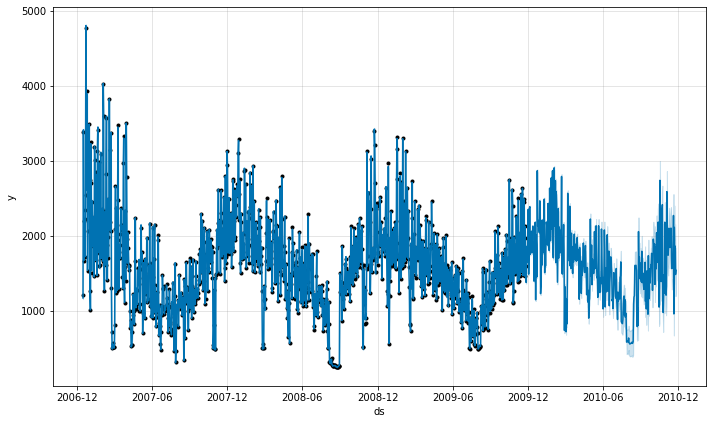

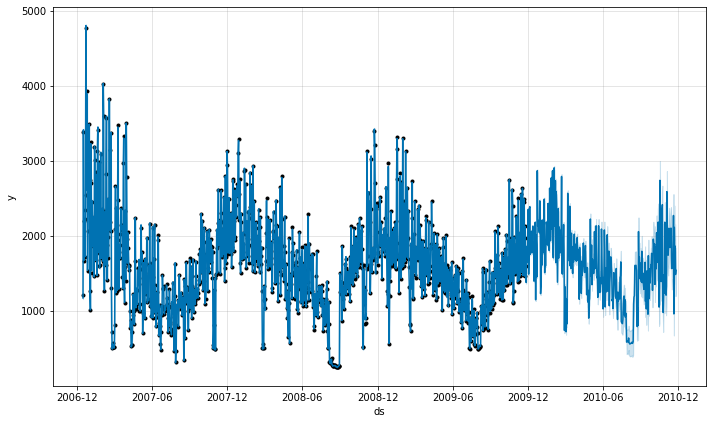

In [43]:
#Plot
model.plot(pred1)

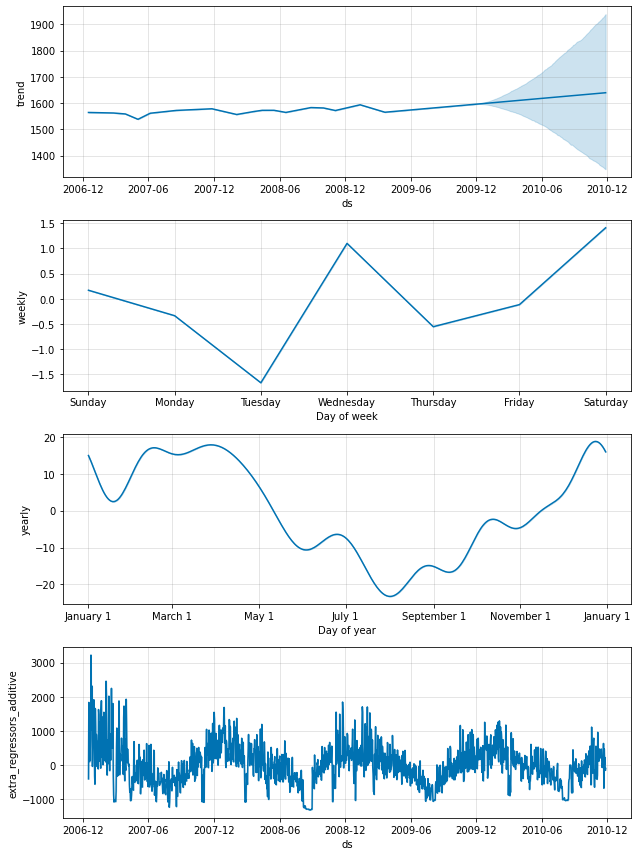

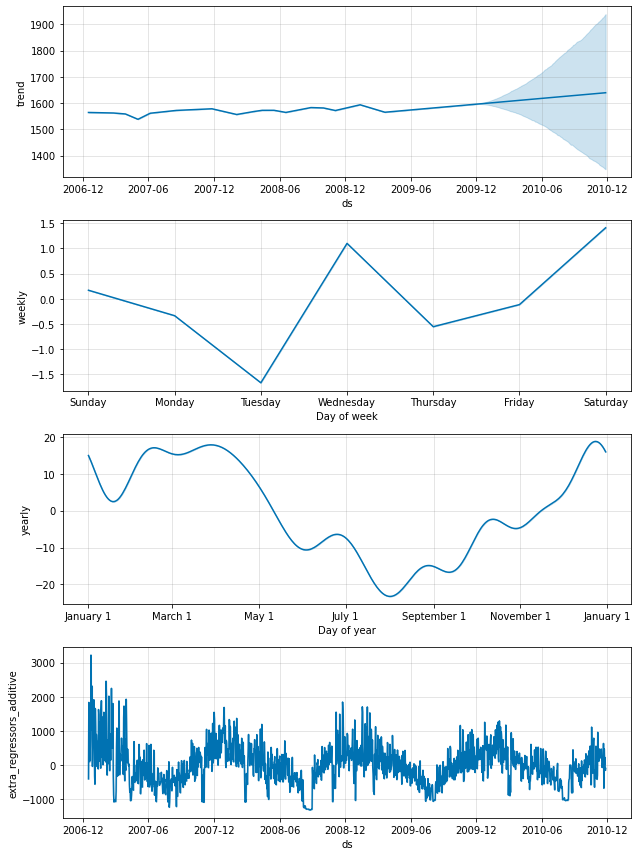

In [44]:
model.plot_components(pred1)

In [45]:
# calculate MAE between expected and predicted values for december
y_true2 = df_index['y'][-365:].values
y_pred2 = pred1['yhat'][-365:].values

In [46]:
MAE = np.mean(np.abs((y_true - y_pred)/y_true))
MAE

0.20884985090046293

In [47]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
round(rmse, 3)

374.953